## Import Libraries & Load Dataset

In [40]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
# Load the Excel file and parse the correct sheet
path = 'https://gitlab.crio.do/me_notebook/me_jupyter_uberanalysis/-/raw/master/Uber_ride_analysis_dataset.csv'
df = pd.read_csv(path,header=0)
df.head()

,Request id,Pickup point,Drop point,Request timestamp,Start timestamp,Drop timestamp,Trip Cost,Extra Tip,Driver id,Trip Status,Ride Type,Payment Method,Weather
0,4386.0,Majestic Bus Station,Bangalore Palace,2021-07-13 0:00:24,NaN,NaN,0.00,0.0,61.0,Trip Cancelled,UberXL,NaN,Clear
1,4387.0,Lalbagh Botanical Garden,Indiranagar,2021-07-13 0:02:14,2021-07-13 0:16:00,2021-07-13 0:26:14,111.38,0.0,17.0,Trip Completed,UberGo,Cash,Cloudy
2,4388.0,Lalbagh Botanical Garden,Kormangala Police Station,2021-07-13 0:06:34,2021-07-13 0:14:01,2021-07-13 2:01:34,89.00,25.0,21.0,Trip Completed,UberXL,Card,Clear
3,4389.0,Majestic Bus Station,ISKCON Temple,2021-07-13 0:07:31,NaN,NaN,0.00,0.0,NaN,No Cars Available,UberXL,NaN,Rainy
4,4390.0,Bangalore City Railway Station,Lalbagh Botanical Garden,2021-07-13 0:07:58,2021-07-13 0:20:21,2021-07-13 0:40:58,307.40,25.0,35.0,Trip Completed,UberGo,Cash,Rainy


## Data Cleaning

In [42]:
# Standardize column names
# Convert to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['request_id', 'pickup_point', 'drop_point', 'request_timestamp',
       'start_timestamp', 'drop_timestamp', 'trip_cost', 'extra_tip',
       'driver_id', 'trip_status', 'ride_type', 'payment_method', 'weather'],
      dtype='object')

In [43]:
# Identify missing values in each column
print(df.isnull().sum())

request_id            200
pickup_point          200
drop_point            200
request_timestamp     200
start_timestamp      1850
drop_timestamp       1850
trip_cost             200
extra_tip             200
driver_id             975
trip_status           200
ride_type             200
payment_method       1850
weather               200
dtype: int64


In [45]:
# Drop rows with missing trip status or trip cost
df = df.dropna(subset=['trip_status', 'trip_cost'])

In [46]:
# Fill missing payment method with mode
df['payment_method'].fillna(df['payment_method'].mode()[0], inplace=True)

In [47]:
# Fill missing driver ID with -1 (indicates unassigned)
df['driver_id'].fillna(-1, inplace=True)

In [48]:
#  Handle timestamps conditionally
# Drop rows where timestamps are missing only for 'Trip Completed'
df = df[~((df['trip_status'] == 'Trip Completed') & (df['start_timestamp'].isna() | df['drop_timestamp'].isna()))]

In [49]:
# Identify missing values in each column
print(df.isnull().sum())

request_id              0
pickup_point            0
drop_point              0
request_timestamp       0
start_timestamp      1650
drop_timestamp       1650
trip_cost               0
extra_tip               0
driver_id               0
trip_status             0
ride_type               0
payment_method          0
weather                 0
dtype: int64


In [50]:
# Convert date columns to datetime
date_columns = ['request_timestamp', 'start_timestamp', 'drop_timestamp']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])

In [51]:
#  List all numeric columns
numeric_columns = df.select_dtypes(include='number').columns.tolist()
print(numeric_columns)

['request_id', 'trip_cost', 'extra_tip', 'driver_id']


## Outlier Detection and Treatment

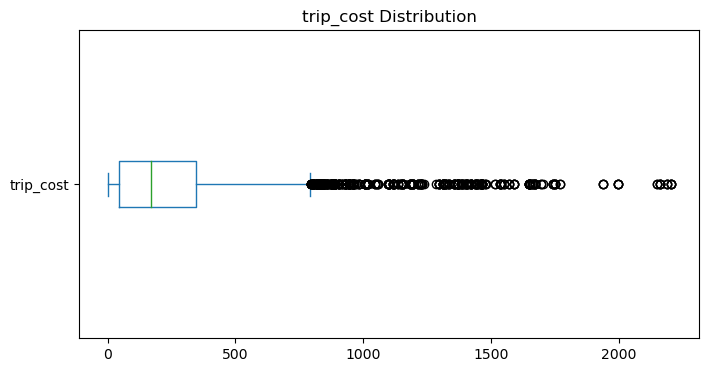

In [52]:
# Plot boxplot for trip cost
plt.figure(figsize=(8, 4))
df['trip_cost'].plot(kind='box', vert=False)
plt.title('trip_cost Distribution')
plt.show()

In [53]:
# Detect and cap outliers in trip cost using IQR
Q1 = df['trip_cost'].quantile(0.25)
Q3 = df['trip_cost'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df['trip_cost'] = np.where(df['trip_cost'] > upper_bound, upper_bound, df['trip_cost'])

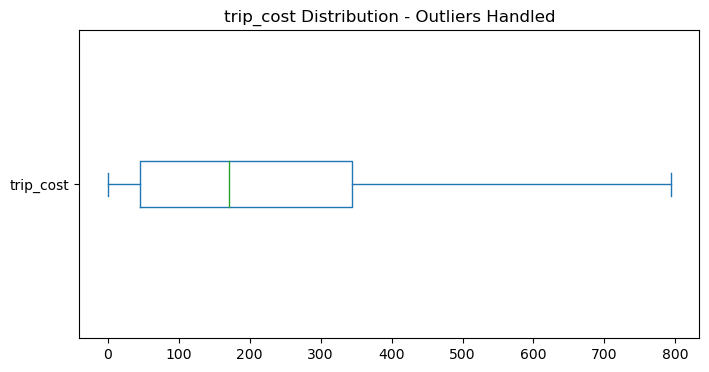

In [54]:
# Plot boxplot for trip cost
plt.figure(figsize=(8, 4))
df['trip_cost'].plot(kind='box', vert=False)
plt.title('trip_cost Distribution - Outliers Handled')
plt.show()

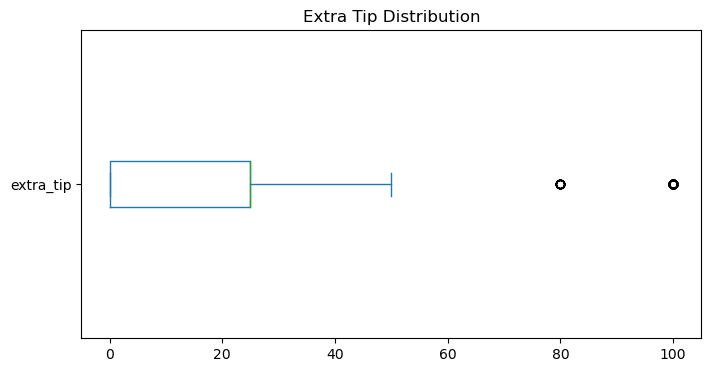

In [55]:
#  Repeat for extra tip
plt.figure(figsize=(8, 4))
df['extra_tip'].plot(kind='box', vert=False)
plt.title('Extra Tip Distribution')
plt.show()


## 📊 Exploratory Data Analysis (EDA)

Now that the data cleaning is done, let's perform EDA to understand the dataset better and derive insights.


## 1. Dataset Overview

In [1]:
# TODO 1.1: Understand the shape of the dataset
print("Dataset Shape (rows, columns):", df.shape)


In [2]:
# TODO 1.2: Understand the datatypes of the columns
print("\nData Types:")
print(df.dtypes)


## 2. Trip Status Breakdown

In [3]:
# TODO 2: Plot the value_counts for different trip statuses
import seaborn as sns

trip_status_counts = df['trip_status'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=trip_status_counts.index, y=trip_status_counts.values, palette='viridis')
plt.title("Trip Status Distribution")
plt.xlabel("Trip Status")
plt.ylabel("Number of Trips")
plt.xticks(rotation=30)
plt.grid(False)
plt.show()


## 3. Trip Cost Distribution

In [4]:
# TODO 3: Plot Trip Cost Distribution
max_cost = int(df['trip_cost'].max())
bins = np.arange(0, max_cost + 100, 100)

plt.figure(figsize=(10, 5))
plt.hist(df['trip_cost'], bins=bins, color='skyblue', edgecolor='black')
plt.title("Trip Cost Distribution")
plt.xlabel("Trip Cost")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()


## 4. Analyze Payment Methods

In [5]:
# TODO 4: Group by payment_method and calculate mean, median, and count of trip_cost
payment_analysis = df.groupby('payment_method')['trip_cost'].agg(['mean', 'median', 'count'])
payment_analysis = payment_analysis.sort_values(by='mean', ascending=False)

print("Trip Cost Analysis by Payment Method:")
print(payment_analysis)


## 5. Trip Duration Analysis


In [6]:
# TODO 5.1: Compute trip duration in minutes
df['trip_duration_min'] = (df['drop_timestamp'] - df['start_timestamp']).dt.total_seconds() / 60


In [7]:
# TODO 5.2: Plot distribution of trip duration in minutes
max_duration = int(df['trip_duration_min'].dropna().max())
bins = np.arange(0, max_duration + 10, 10)

plt.figure(figsize=(10, 5))
plt.hist(df['trip_duration_min'].dropna(), bins=bins, color='salmon', edgecolor='black')
plt.title("Trip Duration Distribution")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()
